In [2]:
!pip install split-folders
!pip install torch-summary

Failed to execute process '/root/my-project/OreColorSorting/myenv/bin/pip'. Reason:
The file '/root/my-project/OreColorSorting/myenv/bin/pip' specified the interpreter '/mnt/c/Users/食草龙/Desktop/毕业设计/我的毕设/OreColorSorting/myenv/bin/python3', which is not an executable command.


Failed to execute process '/root/my-project/OreColorSorting/myenv/bin/pip'. Reason:
The file '/root/my-project/OreColorSorting/myenv/bin/pip' specified the interpreter '/mnt/c/Users/食草龙/Desktop/毕业设计/我的毕设/OreColorSorting/myenv/bin/python3', which is not an executable command.


In [2]:
import warnings     
warnings.filterwarnings('ignore')
import pathlib                                                                      
import numpy as np    
import pandas as pd
import matplotlib.pyplot as plt                  
import seaborn as sns  
import os       
import random
import splitfolders                               
from termcolor import colored                     

from tensorflow import keras 
import torch                  
import torch.nn as nn          # To work with Neural Networks
import torchvision 
import torch.nn.functional as F
import torch.utils.data

import torchvision.transforms as transforms  
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.io import read_image # For visualization
from torchvision.datasets import ImageFolder

In [3]:
data_folder = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

In [4]:
rice_classes = os.listdir(data_folder)
rice_classes

['Karacadag',
 'Basmati',
 'Jasmine',
 'Rice_Citation_Request.txt',
 'Arborio',
 'Ipsala']

In [5]:
rice_classes.remove('Rice_Citation_Request.txt')
num_classes = len(rice_classes) # Get number of classes
print(f'There are {num_classes} class: ', rice_classes)

There are 5 class:  ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']


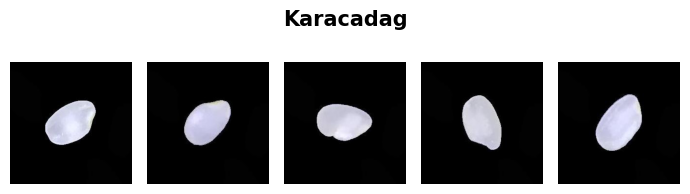

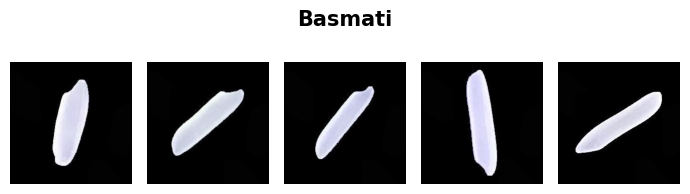

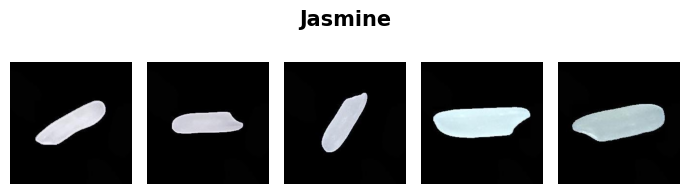

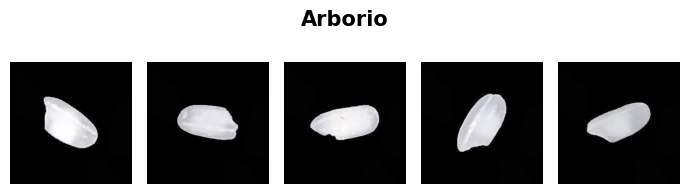

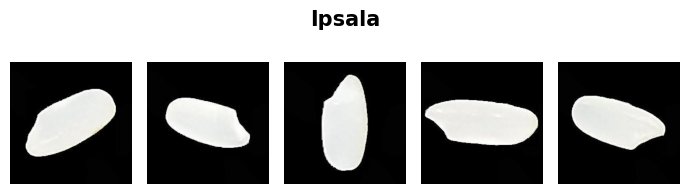

In [6]:
for class_name in rice_classes:
    class_path = os.path.join(data_folder, class_name)

    images = os.listdir(class_path)

    random_images = random.choices(images, k=5)
    fig, ax = plt.subplots(1, 5, figsize=(7, 2)) #1 row and 5 columns

    for i in range(5):
        plt.suptitle(class_name, fontsize=15, fontweight='bold')

        img_path = os.path.join(class_path, random_images[i])

        img = read_image(img_path)  
        img = transforms.ToPILImage()(img) 

        ax[i].imshow(img)
        ax[i].axis('off')  

    plt.tight_layout()  
    plt.show() 

In [7]:
# Splitting the data into three folders
splitfolders.ratio(data_folder, output='data_splitted' , seed=42, ratio=(0.75, 0.15, 0.1))

Copying files: 75000 files [09:06, 137.17 files/s]


In [8]:
new1_dir = '/kaggle/working/data_splitted'
new1_dir = pathlib.Path(new1_dir)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
transform = transforms.Compose([
        transforms.Resize((250,250)) ,
        transforms.ToTensor() ,
        transforms.Normalize((0),(1))])

In [11]:
Batch = 32

train_set = ImageFolder(new1_dir.joinpath("train"), transform=transform)
train_loader = DataLoader(train_set, batch_size=Batch, shuffle=True)

print(colored(f'Train Folder:\n{train_set}\n *******************************************************',
              'blue', attrs=['bold']))

val_set = ImageFolder(new1_dir.joinpath("val"), transform=transform)
val_loader = DataLoader(val_set, batch_size=Batch, shuffle = False)

print(colored(f'Validation Folder:\n{val_set}\n *******************************************************',
              'blue', attrs=['bold']))

test_set = ImageFolder(new1_dir.joinpath("test"), transform=transform)
test_loader = DataLoader(test_set, batch_size=Batch, shuffle = False)

print(colored(f'Test Folder:\n{test_set}\n *******************************************************',
              'blue', attrs=['bold']))

Train Folder:
Dataset ImageFolder
    Number of datapoints: 56250
    Root location: /kaggle/working/data_splitted/train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0, std=1)
           )
 *******************************************************
Validation Folder:
Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/data_splitted/val
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0, std=1)
           )
 *******************************************************
Test Folder:
Dataset ImageFolder
    Number of datapoints: 7500
    Root location: /kaggle/working/data_splitted/test
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolatio

In [12]:
def print_loader_shapes(loaders):
    for key, value in loaders.items():
        X, y = next(iter(value))  # Get the first batch
        print(colored(f'{key}:', 'green', attrs=['bold']))
        print(f"Images shape: {X.shape}")
        print(f"Labels shape: {y.shape} {y.dtype}\n")
        print('*****************************************')
        
loaders = {'Train': train_loader, 'Validation': val_loader, 'Test': test_loader}
print_loader_shapes(loaders)

Train:
Images shape: torch.Size([32, 3, 250, 250])
Labels shape: torch.Size([32]) torch.int64

*****************************************
Validation:
Images shape: torch.Size([32, 3, 250, 250])
Labels shape: torch.Size([32]) torch.int64

*****************************************
Test:
Images shape: torch.Size([32, 3, 250, 250])
Labels shape: torch.Size([32]) torch.int64

*****************************************


In [13]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 62 * 62, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 62 * 62)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN(num_classes = 5)
summary(model, (3, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 250, 250]        896
├─MaxPool2d: 1-2                         [-1, 32, 125, 125]        --
├─Conv2d: 1-3                            [-1, 64, 125, 125]        18,496
├─MaxPool2d: 1-4                         [-1, 64, 62, 62]          --
├─Linear: 1-5                            [-1, 120]                 29,522,040
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 29,552,021
Trainable params: 29,552,021
Non-trainable params: 0
Total mult-adds (M): 371.53
Input size (MB): 0.72
Forward/backward pass size (MB): 22.89
Params size (MB): 112.73
Estimated Total Size (MB): 136.34


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 250, 250]        896
├─MaxPool2d: 1-2                         [-1, 32, 125, 125]        --
├─Conv2d: 1-3                            [-1, 64, 125, 125]        18,496
├─MaxPool2d: 1-4                         [-1, 64, 62, 62]          --
├─Linear: 1-5                            [-1, 120]                 29,522,040
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 29,552,021
Trainable params: 29,552,021
Non-trainable params: 0
Total mult-adds (M): 371.53
Input size (MB): 0.72
Forward/backward pass size (MB): 22.89
Params size (MB): 112.73
Estimated Total Size (MB): 136.34

In [14]:
model = CNN(num_classes).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Initialize lists to keep track of metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()               # Zero the parameter gradients
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        
        # Store training metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval() 
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total
        
        # Store validation metrics
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch statistics
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    metrics_df = pd.DataFrame({
        'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Train Accuracy': train_accuracies,
        'Val Loss': val_losses,
        'Val Accuracy': val_accuracies
    })
    
    return metrics_df

In [17]:
metrics_df = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.1304, Train Accuracy: 0.9544, Val Loss: 0.0978, Val Accuracy: 0.9655
Epoch [2/10], Train Loss: 0.0544, Train Accuracy: 0.9815, Val Loss: 0.0308, Val Accuracy: 0.9902
Epoch [3/10], Train Loss: 0.0335, Train Accuracy: 0.9883, Val Loss: 0.0215, Val Accuracy: 0.9932
Epoch [4/10], Train Loss: 0.0254, Train Accuracy: 0.9920, Val Loss: 0.0310, Val Accuracy: 0.9909
Epoch [5/10], Train Loss: 0.0212, Train Accuracy: 0.9934, Val Loss: 0.0214, Val Accuracy: 0.9933
Epoch [6/10], Train Loss: 0.0178, Train Accuracy: 0.9942, Val Loss: 0.0354, Val Accuracy: 0.9892
Epoch [7/10], Train Loss: 0.0155, Train Accuracy: 0.9946, Val Loss: 0.0366, Val Accuracy: 0.9890
Epoch [8/10], Train Loss: 0.0117, Train Accuracy: 0.9964, Val Loss: 0.0309, Val Accuracy: 0.9909
Epoch [9/10], Train Loss: 0.0114, Train Accuracy: 0.9964, Val Loss: 0.0371, Val Accuracy: 0.9909
Epoch [10/10], Train Loss: 0.0198, Train Accuracy: 0.9938, Val Loss: 0.0468, Val Accuracy: 0.9846


In [18]:
metrics_df

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,1,0.130357,0.954436,0.097778,0.965511
1,2,0.054443,0.981458,0.030781,0.990222
2,3,0.033544,0.988302,0.021473,0.993244
3,4,0.025398,0.991964,0.030982,0.990933
4,5,0.021202,0.993404,0.021369,0.993333
5,6,0.017768,0.994222,0.035396,0.989156
6,7,0.015481,0.994631,0.036646,0.988978
7,8,0.011749,0.996427,0.030915,0.990933
8,9,0.011404,0.996391,0.037062,0.990933
9,10,0.019812,0.993849,0.046823,0.984622


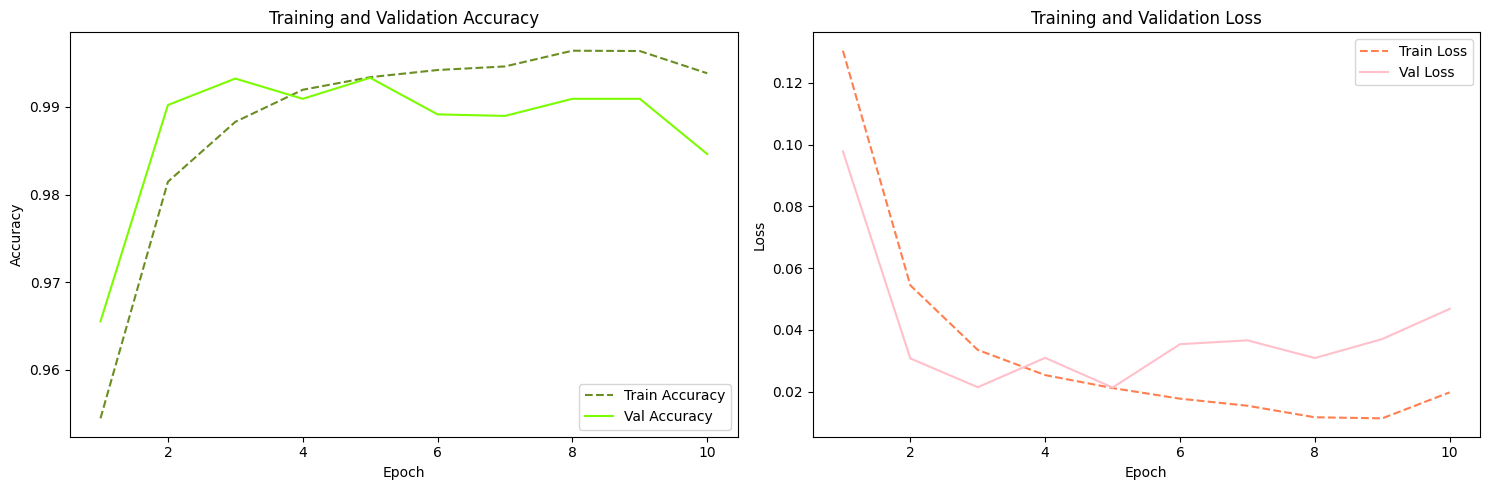

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axs[0].plot(metrics_df['Epoch'], metrics_df['Train Accuracy'],'--r',color='olivedrab', label='Train Accuracy')
axs[0].plot(metrics_df['Epoch'], metrics_df['Val Accuracy'],color = 'lawngreen', label='Val Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
    
# Plot loss
axs[1].plot(metrics_df['Epoch'], metrics_df['Train Loss'],'--r',color = 'coral', label='Train Loss')
axs[1].plot(metrics_df['Epoch'], metrics_df['Val Loss'],color = 'pink', label='Val Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()